# Geographical distribution and coverage of signature types

In [19]:
import xarray
import rioxarray
import numpy
import geopandas
import pandas
import contextily
import matplotlib
import matplotlib.pyplot as plt
import urbangrammar_graphics as ugg
import dask.dataframe as dd
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar

# import squarify

## Geographical distribution along N-S and E-W axes

In [3]:
signatures = rioxarray.open_rasterio("../../urbangrammar_samba/spatial_signatures/signatures/signatures_raster.tif")

In [4]:
unique = numpy.unique(signatures[0])
unique = unique[~numpy.isnan(unique)]

In [6]:
outliers = [93, 96, 97, 98]
unique = unique[~numpy.isin(unique, outliers)]

In [7]:
total_by_row = signatures[0].count("x")
total_by_col = signatures[0].count("y")

In [8]:
types = {
    0: "Countryside agriculture",
    10: "Accessible suburbia",
    30: "Open sprawl",
    40: "Wild countryside",
    50: "Warehouse/Park land",
    60: "Gridded residential quarters",
    70: "Urban buffer",
    80: "Disconnected suburbia",
    20: "Dense residential neighbourhoods",
    21: "Connected residential neighbourhoods",
    22: "Dense urban neighbourhoods",
    90: "Local urbanity",
    91: "Concentrated urbanity",
    92: "Regional urbanity",
    94: "Metropolitan urbanity",
    95: "Hyper concentrated urbanity",
}

In [9]:
proportion_by_lat = {}
proportion_by_lon = {}

for label in unique:
    proportion_by_lat[types[label]] = ((signatures[0] == label).sum("x") / total_by_row)
    proportion_by_lon[types[label]] = ((signatures[0] == label).sum("y") / total_by_col)

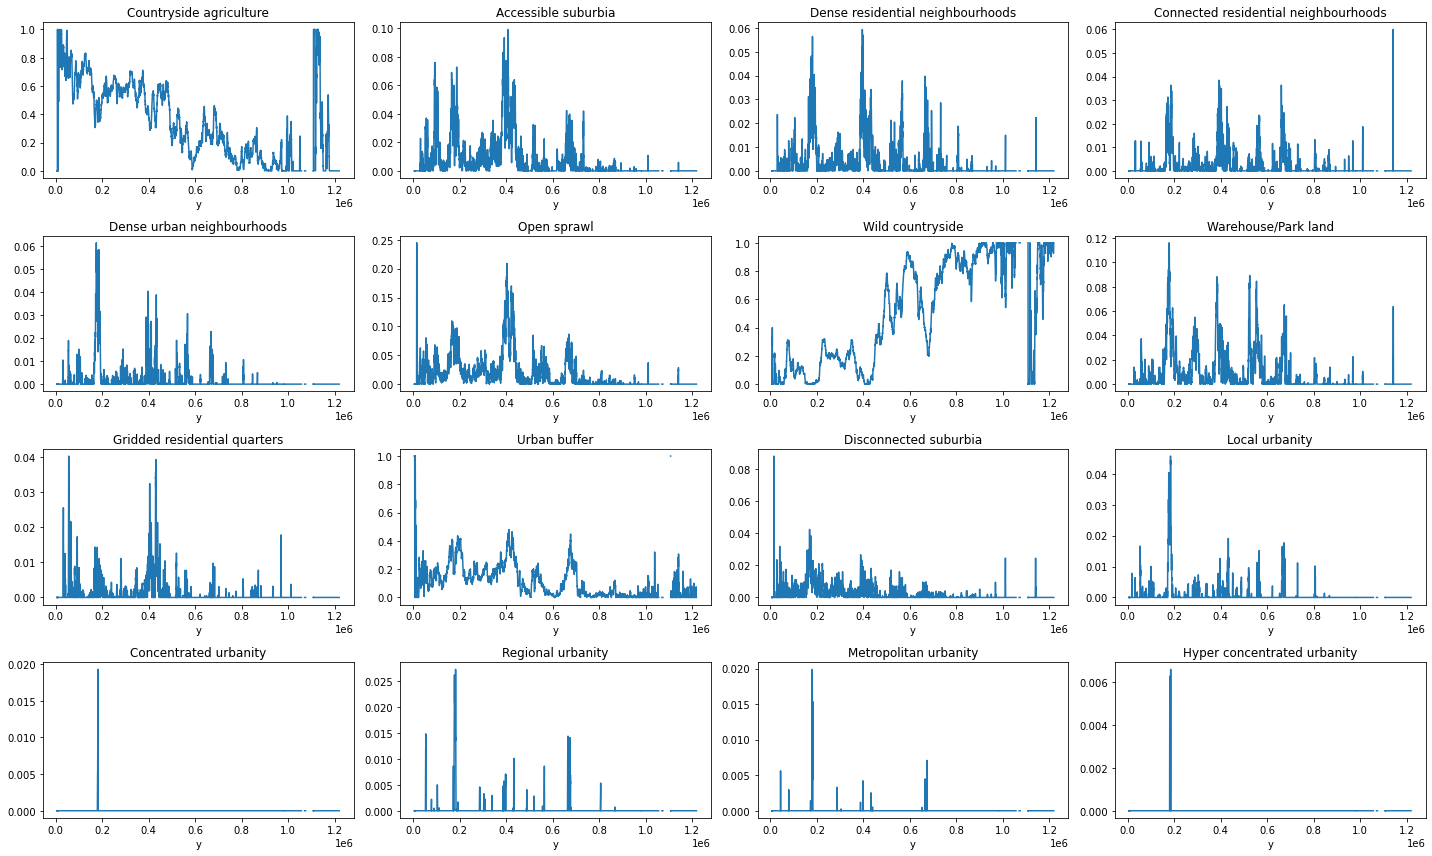

In [10]:
fig, axs = plt.subplots(4, 4, figsize=(20, 12))

for label, ax in zip(proportion_by_lat, axs.flatten()):
    proportion_by_lat[label].plot(ax=ax)
    ax.set_title(label)
plt.tight_layout()

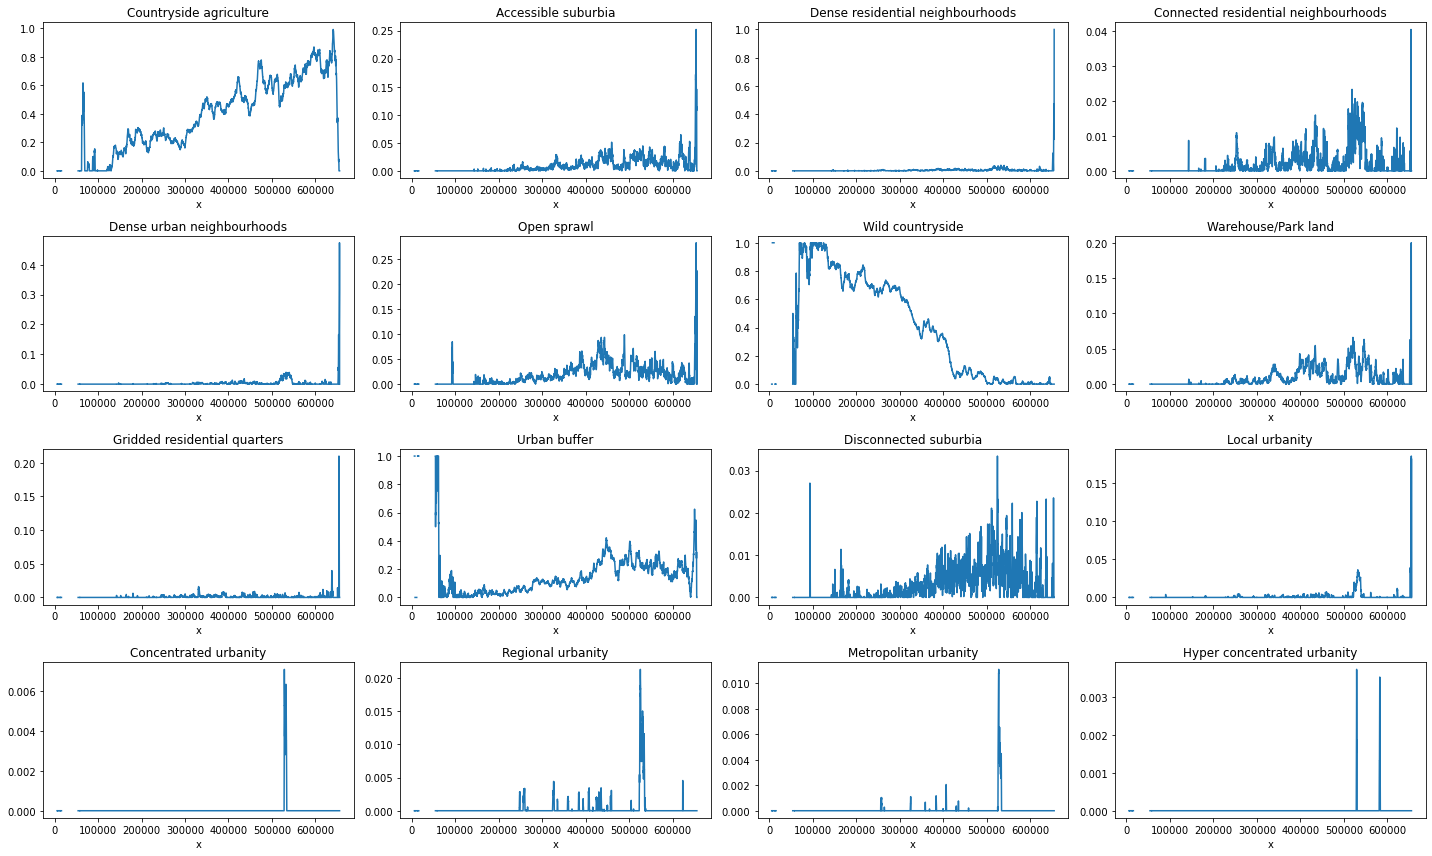

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(20, 12))

for label, ax in zip(proportion_by_lon, axs.flatten()):
    proportion_by_lon[label].plot(ax=ax)
    ax.set_title(label)
plt.tight_layout()

### Resample and assign color

In [13]:
types = {
    "0_0": "Countryside agriculture",
    "1_0": "Accessible suburbia",
    "3_0": "Open sprawl",
    "4_0": "Wild countryside",
    "5_0": "Warehouse/Park land",
    "6_0": "Gridded residential quarters",
    "7_0": "Urban buffer",
    "8_0": "Disconnected suburbia",
    "2_0": "Dense residential neighbourhoods",
    "2_1": "Connected residential neighbourhoods",
    "2_2": "Dense urban neighbourhoods",
    "9_0": "Local urbanity",
    "9_1": "Concentrated urbanity",
    "9_2": "Regional urbanity",
    "9_4": "Metropolitan urbanity",
    "9_5": "Hyper concentrated urbanity",
}

In [190]:
cmap = ugg.get_colormap(20, randomize=False)
cols = cmap.colors

symbology = {'0_0': cols[16],
             '1_0': cols[15],
             '3_0': cols[9],
             '4_0': cols[12],
             '5_0': cols[21],
             '6_0': cols[8],
             '7_0': cols[4],
             '8_0': cols[18],
             '2_0': cols[6],
             '2_1': cols[23],
             '2_2': cols[19],
             '9_0': cols[7],
             '9_1': cols[3],
             '9_2': cols[22],
             '9_4': cols[11],
             '9_5': cols[14],
            }
symbology = {types[k]:v for k, v in symbology.items()}

In [149]:
sig = "Countryside agriculture"
x = proportion_by_lat[sig].fillna(0).values
y = proportion_by_lat[sig].y.values
lat = numpy.linspace(proportion_by_lat[sig].y.max(), proportion_by_lat[sig].y.min(), 100, endpoint=False)
f = []
for i, v in enumerate(lat):
    try:
        mask = (v > y) & (y > lat[i+1])
    except:
        mask = v > y
    f.append(x[mask].mean())

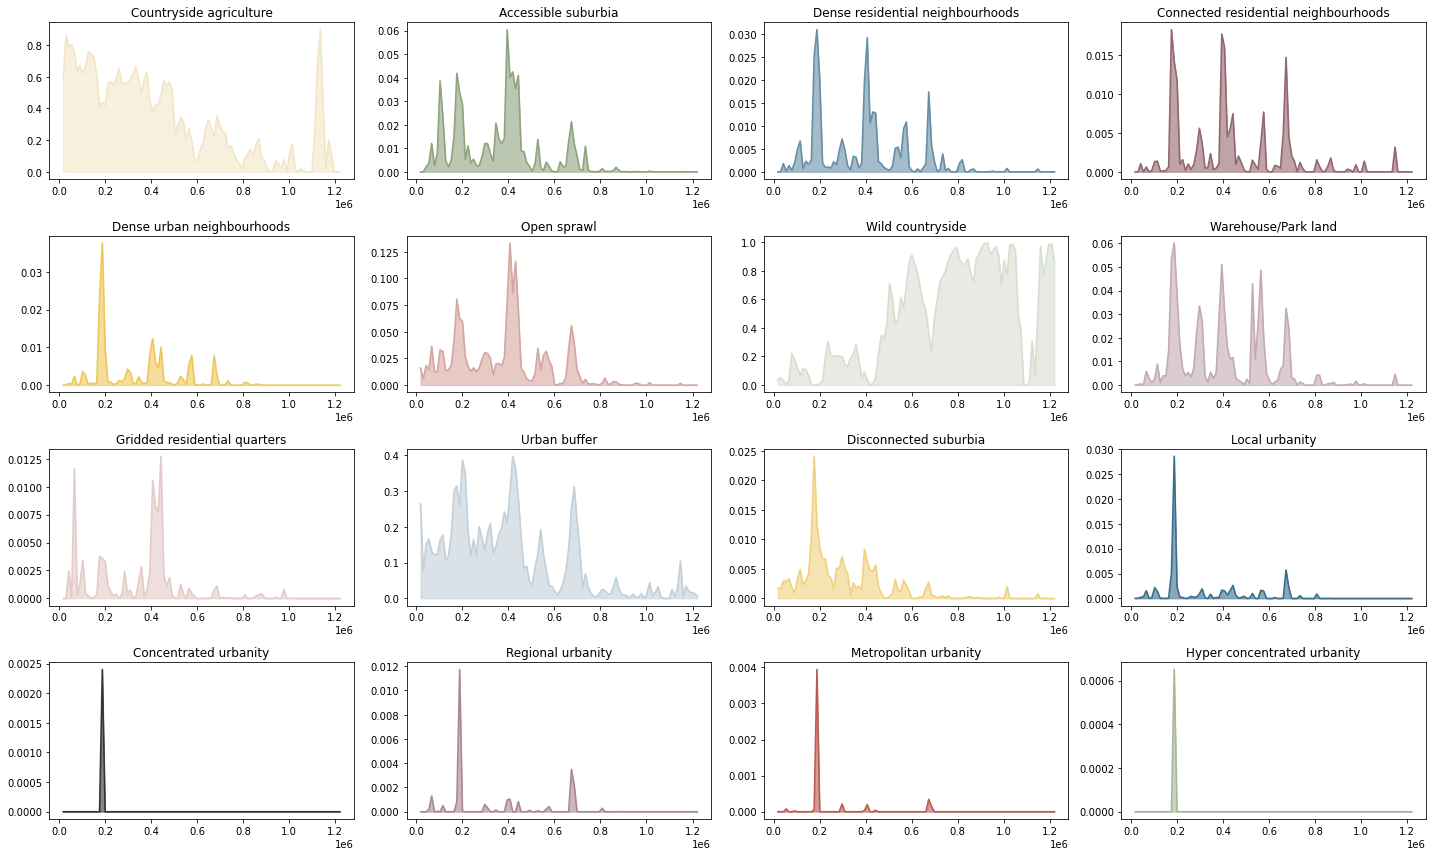

In [153]:
fig, axs = plt.subplots(4, 4, figsize=(20, 12))

for sig, ax in zip(proportion_by_lat, axs.flatten()):
    x = proportion_by_lat[sig].fillna(0).values
    y = proportion_by_lat[sig].y.values
    lat = np.linspace(proportion_by_lat[sig].y.max(), proportion_by_lat[sig].y.min(), 100, endpoint=False)
    f = []
    for i, v in enumerate(lat):
        try:
            mask = (v > y) & (y > lat[i+1])
        except:
            mask = v > y
        f.append(x[mask].mean())
    ax.plot(lat, f, color=symbology[sig])
    ax.fill_between(lat, 0, f, color=symbology[sig], alpha=.6)
    ax.set_title(sig)
plt.tight_layout()
plt.savefig("figs/by_lat.pdf")

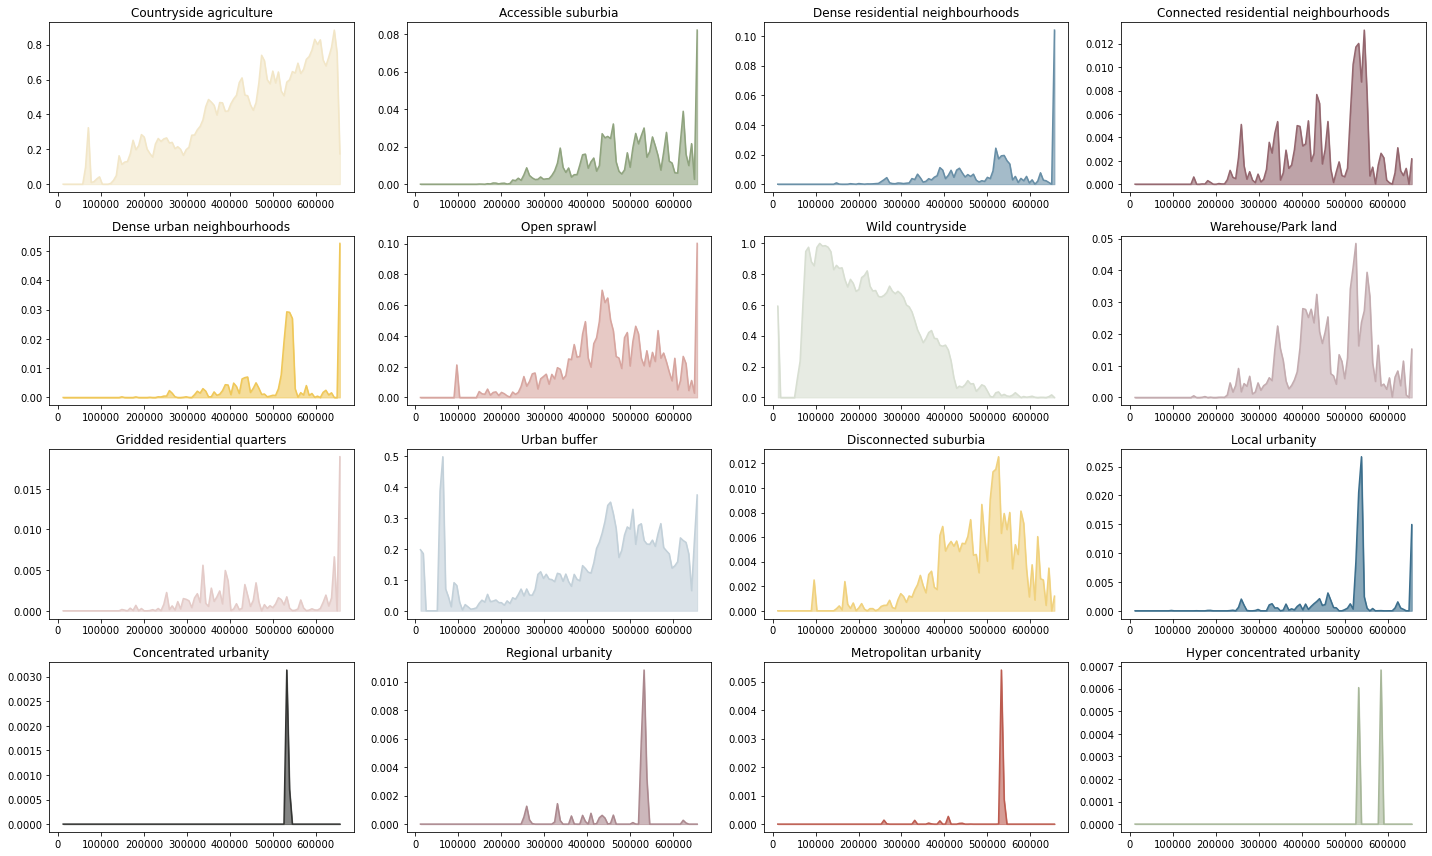

In [156]:
fig, axs = plt.subplots(4, 4, figsize=(20, 12))

for sig, ax in zip(proportion_by_lat, axs.flatten()):
    x = proportion_by_lon[sig].fillna(0).values
    y = proportion_by_lon[sig].x.values
    lat = np.linspace(proportion_by_lon[sig].x.max(), proportion_by_lon[sig].x.min(), 100, endpoint=False)
    f = []
    for i, v in enumerate(lat):
        try:
            mask = (v > y) & (y > lat[i+1])
        except:
            mask = v > y
        f.append(x[mask].mean())
    ax.plot(lat, f, color=symbology[sig])
    ax.fill_between(lat, 0, f, color=symbology[sig], alpha=.6)
    ax.set_title(sig)
plt.tight_layout()
plt.savefig("figs/by_lon.pdf")

Plot map

In [157]:
signatures = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_levels_simplified.pq")
signatures["signature_type"] = signatures["signature_type"].map(types)

In [158]:
signatures = signatures.dropna()

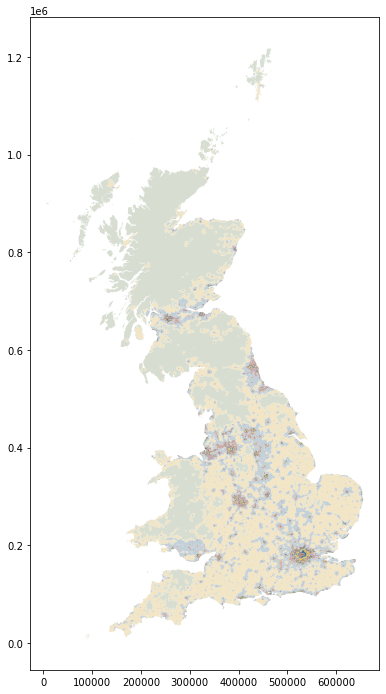

In [160]:
signatures.plot(figsize=(12, 12), color=signatures["signature_type"].map(symbology))
plt.savefig("figs/signature_map.png", dpi=300)

## Coverage

In [175]:
signatures["area"] = signatures.area
types_sum = signatures[["area", "signature_type"]].groupby("signature_type").sum()

In [37]:
types_sum

,area
signature_type,
Accessible suburbia,2.244586e+09
Concentrated urbanity,7.883216e+06
Connected residential neighbourhoods,5.654034e+08
Countryside agriculture,9.385615e+10
Dense residential neighbourhoods,9.572622e+08
Dense urban neighbourhoods,5.706291e+08
Disconnected suburbia,7.089617e+08
Gridded residential quarters,2.612541e+08
Hyper concentrated urbanity,2.293596e+06


(0.0, 100.0, 0.0, 100.0)

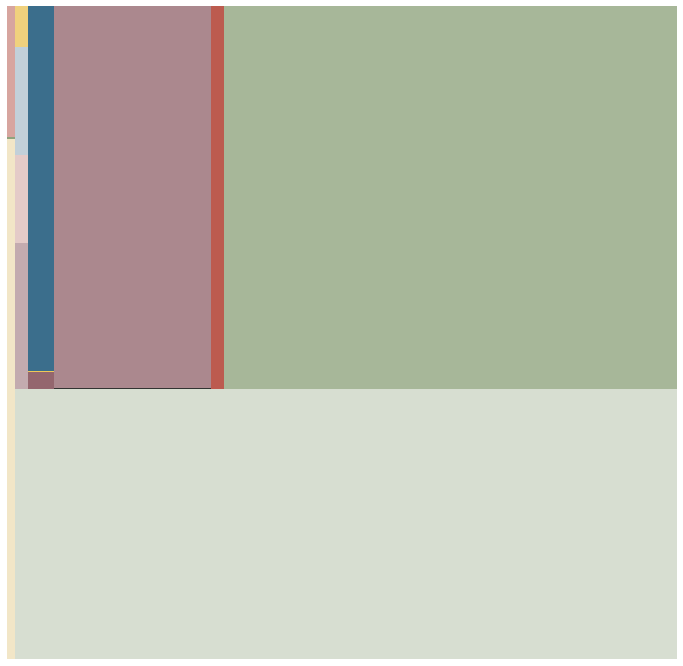

In [38]:
fig, ax = plt.subplots(figsize=(12, 12))
squarify.plot(sizes=types_sum.area, pad=False, ax=ax, color=list(symbology.values()))
ax.axis('off')

In [193]:
types_sum["color"] = [symbology[c] for c in types_sum.index]

In [194]:
types_sum

,area,color
signature_type,,
Accessible suburbia,2.244586e+09,"(0.5625, 0.640625, 0.4921875)"
Concentrated urbanity,7.883216e+06,"(0.19921875, 0.203125, 0.1953125)"
Connected residential neighbourhoods,5.654034e+08,"(0.58203125, 0.3984375, 0.4296875)"
Countryside agriculture,9.385615e+10,"(0.9475259828670731, 0.9021947232500418, 0.782..."
Dense residential neighbourhoods,9.572622e+08,"(0.405436326872467, 0.5568241504426759, 0.6493..."
Dense urban neighbourhoods,5.706291e+08,"(0.9375, 0.78125, 0.34375)"
Disconnected suburbia,7.089617e+08,"(0.9408069995844273, 0.8211427621191237, 0.488..."
Gridded residential quarters,2.612541e+08,"(0.8956450438496885, 0.7949476416458632, 0.782..."
Hyper concentrated urbanity,2.293596e+06,"(0.6550082934095629, 0.716277287243688, 0.6001..."


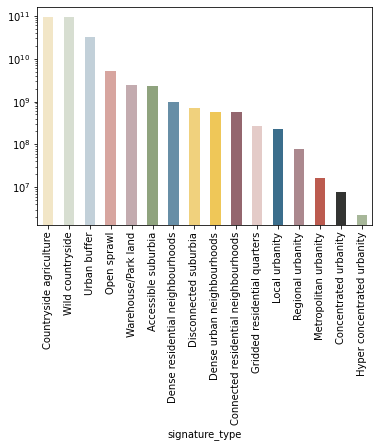

In [195]:
types_sum = types_sum.sort_values("area", ascending=False)
ax = types_sum.area.plot.bar(color=types_sum.color)
ax.set_yscale("log")

In [255]:
types_sum.sort_values("area", ascending=False).index

Index(['Countryside agriculture', 'Wild countryside', 'Urban buffer',
       'Open sprawl', 'Warehouse/Park land', 'Accessible suburbia',
       'Dense residential neighbourhoods', 'Disconnected suburbia',
       'Dense urban neighbourhoods', 'Connected residential neighbourhoods',
       'Gridded residential quarters', 'Local urbanity', 'Regional urbanity',
       'Metropolitan urbanity', 'Concentrated urbanity',
       'Hyper concentrated urbanity'],
      dtype='object', name='signature_type')

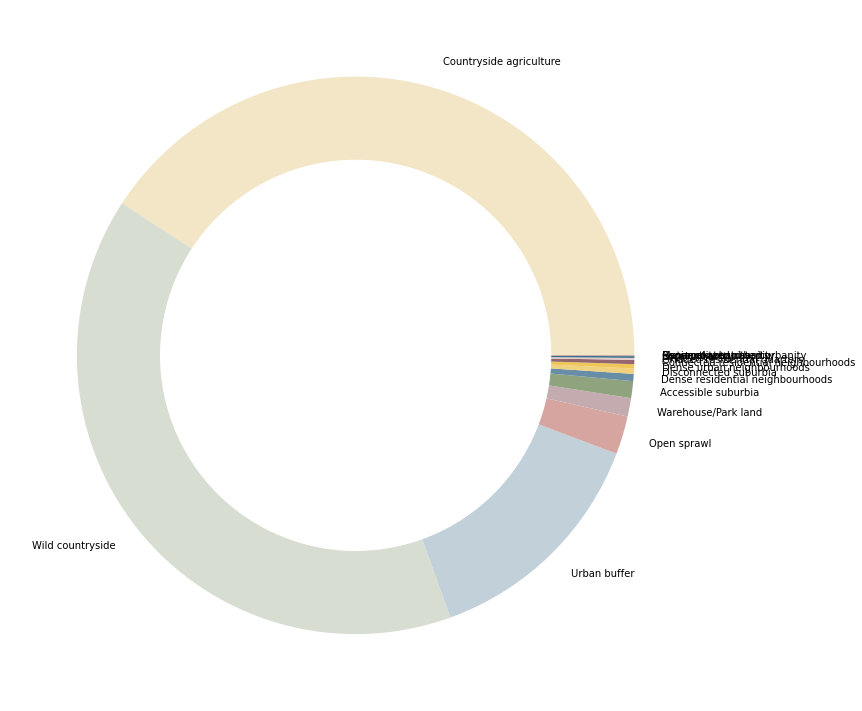

In [55]:
fig, ax = plt.subplots(figsize=(12, 12))
types_sum.area.plot.pie(colors=types_sum.color, labels=types_sum.index, ax=ax, normalize=True)
ax.axis("off")
ax.add_artist(plt.Circle((0,0), .7, color="w"))

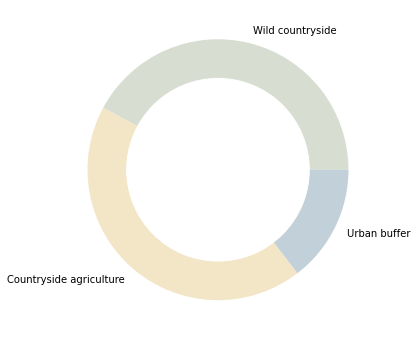

In [240]:
countryside = types_sum.loc[["Wild countryside", "Countryside agriculture", "Urban buffer"]]

fig, ax = plt.subplots(figsize=(6, 6))
countryside.area.plot.pie(colors=countryside.color, labels=countryside.index, ax=ax, normalize=True)
ax.axis("off")
ax.add_artist(plt.Circle((0,0), .7, color="w"))
plt.savefig("fig/cov_countryside.pdf")

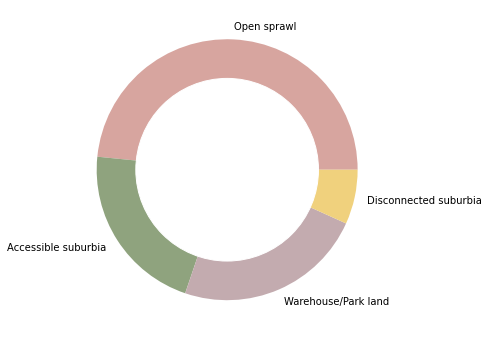

In [241]:
periphery = types_sum.loc[["Open sprawl", "Accessible suburbia", "Warehouse/Park land", "Disconnected suburbia"]]

fig, ax = plt.subplots(figsize=(6, 6))
periphery.area.plot.pie(colors=periphery.color, labels=periphery.index, ax=ax, normalize=True)
ax.axis("off")
ax.add_artist(plt.Circle((0,0), .7, color="w"))
plt.savefig("fig/cov_periphery.pdf")

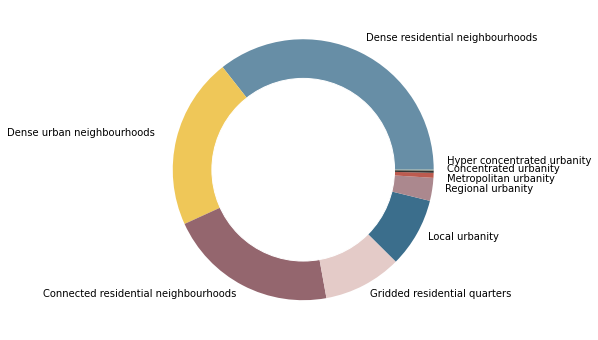

In [253]:
centres = types_sum.loc[[c for c in types_sum.index if c not in periphery.index.union(countryside.index)]]

fig, ax = plt.subplots(figsize=(6, 6))
centres.area.plot.pie(colors=centres.color, labels=None, ax=ax, normalize=True)
ax.axis("off")
ax.add_artist(plt.Circle((0,0), .7, color="w"))
ax.text(0.48081342961609136, 0.9893525387347082, 'Dense residential neighbourhoods')
ax.text(-2.268978614659921, 0.2593929864120394, 'Dense urban neighbourhoods')
ax.text(-1.994807053876901, -0.9748996927056968, 'Connected residential neighbourhoods')
ax.text(0.51211504741639, -0.9735184529374411, 'Gridded residential quarters')
ax.text(0.959363500900176, -0.538165098404345, 'Local urbanity')
ax.text(1.087344357909379, -0.16637982847280644, 'Regional urbanity')
ax.text(1.098975902527664, -0.08745488029177633, 'Metropolitan urbanity')
ax.text(1.0998832541521082, -0.01602583026770399, 'Concentrated urbanity')
ax.text(1.09999605164628, 0.045, 'Hyper concentrated urbanity')
plt.savefig("fig/cov_centres.pdf")

In [263]:
london = geopandas.GeoSeries([Point(-0.10875602230396436, 51.50933674406198)], crs=4326).to_crs(27700).buffer(35000).total_bounds

In [266]:
df = signatures.cx[london[0]:london[2], london[1]:london[3]].to_crs(3857)

In [280]:
centre_types = ['Hyper concentrated urbanity', 'Concentrated urbanity', 'Metropolitan urbanity', 'Regional urbanity', 'Local urbanity', 'Dense urban neighbourhoods']

df_centres = df.loc[df.signature_type.isin(centre_types)]
df_out = df.loc[~df.signature_type.isin(centre_types)]

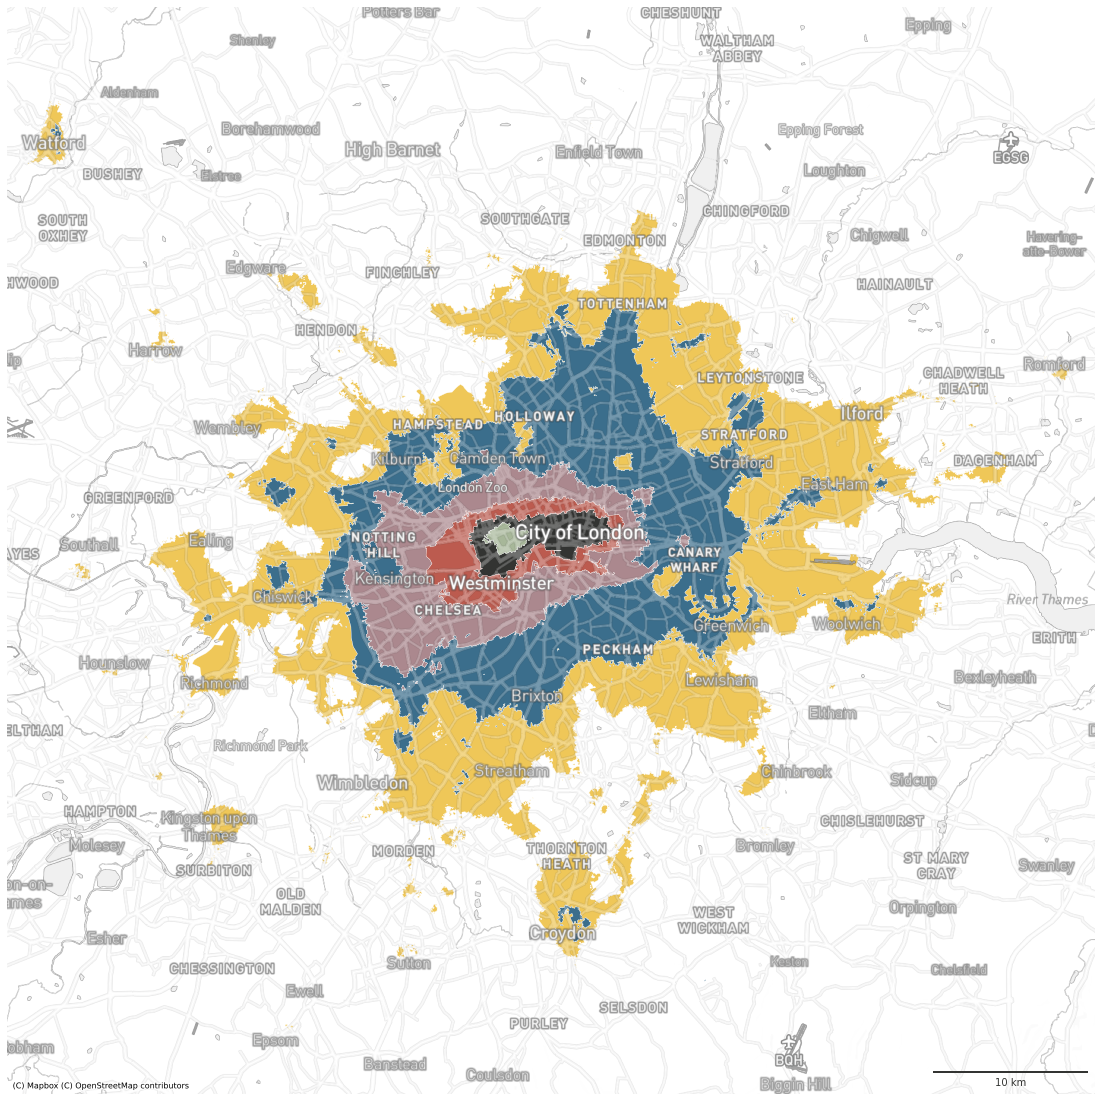

In [287]:
ax = df_centres.plot(color=df_centres['signature_type'].map(symbology), figsize=(20, 20), zorder=1, linewidth=.3, edgecolor='w', alpha=1)
# df_out.plot(ax=ax, color=df_out['signature_type'].map(symbology), zorder=1, linewidth=.3, edgecolor='w', alpha=.5)

london = geopandas.GeoSeries([Point(-0.10875602230396436, 51.50933674406198)], crs=4326).to_crs(3857).buffer(35000).total_bounds
ax.set_xlim(london[0], london[2])
ax.set_ylim(london[1], london[3])

contextily.add_basemap(ax, crs=df_centres.crs, source=ugg.get_tiles('roads', token), zorder=2, alpha=.3)
contextily.add_basemap(ax, crs=df_centres.crs, source=ugg.get_tiles('labels', token), zorder=3, alpha=1)
contextily.add_basemap(ax, crs=df_centres.crs, source=ugg.get_tiles('background', token), zorder=-1, alpha=1)
ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    color=ugg.COLORS[0],
                    location='lower right',
                    height_fraction=0.002,
                    pad=.5,
                    frameon=False,
                    )
ax.add_artist(scalebar)

# ugg.north_arrow(plt.gcf(), ax, 0, size=.05, linewidth=1, color=ugg.COLORS[0], loc="upper left", pad=.002, alpha=.9)

# custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in symbology.values()]
# leg_points = ax.legend(custom_points, symbology.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
# ax.add_artist(leg_points)
plt.savefig("figs/signatures_london_centres.png", dpi=72, bbox_inches="tight")

### Count of tessellation cells by type

In [7]:
import geopandas
import dask_geopandas
import pandas

In [4]:
tess = dask_geopandas.read_parquet(f"../../urbangrammar_samba/spatial_signatures/tessellation/tess_*.pq")

In [8]:
labels_l1 = pandas.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/KMeans10GB.pq")
labels_l2_9 = pandas.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/clustergram_cl9_labels.pq")
labels_l2_2 = pandas.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/subclustering_cluster2_k3.pq")
labels = labels_l1.copy()
labels.loc[labels.kmeans10gb == 9, 'kmeans10gb'] = labels_l2_9['9'].values + 90
labels.loc[labels.kmeans10gb == 2, 'kmeans10gb'] = labels_l2_2['subclustering_cluster2_k3'].values + 20

outliers = [98, 93, 96, 97]
mask = ~labels.kmeans10gb.isin(outliers)

In [11]:
labels[mask]["kmeans10gb"].value_counts().to_csv("../../urbangrammar_samba/spatial_signatures/esda/counts.csv")

In [12]:
labels[mask]["kmeans10gb"].value_counts()

7     3686554
0     3022385
3     2561211
1     1962830
5      707211
4      595902
8      564318
20     502835
21     374090
22     238639
6      209959
90      86380
92      21760
94       3739
91       1390
95        264
Name: kmeans10gb, dtype: int64

In [4]:
signatures = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_levels_simplified.pq")

signatures["area"] = signatures.area
types_sum = signatures[["area", "signature_type"]].groupby("signature_type").sum()

In [5]:
counts = pandas.read_csv("../../urbangrammar_samba/spatial_signatures/esda/counts.csv", index_col=0
                        )

In [6]:
types_sum

,area
signature_type,
0_0,9.385615e+10
1_0,2.244586e+09
2_0,9.572622e+08
2_1,5.654034e+08
2_2,5.706291e+08
3_0,5.081598e+09
4_0,9.130631e+10
5_0,2.462472e+09
6_0,2.612541e+08


In [7]:
idx = []
for i in counts.index:
    i = str(i)
    if len(i) == 1:
        idx.append(i + "_0")
    else:
        idx.append(i[0] + "_" + i[1])

In [8]:
counts

,kmeans10gb
7,3686554
0,3022385
3,2561211
1,1962830
5,707211
4,595902
8,564318
20,502835
21,374090
22,238639


In [9]:
counts.index = idx

In [10]:
types_sum['counts'] = counts.kmeans10gb

In [11]:
types_sum = types_sum.dropna()

In [14]:
types_sum.index = types_sum.index.map(types)

In [15]:
types_sum["area_perc"] = (types_sum.area / types_sum.area.sum()) * 100
types_sum["count_perc"] = (types_sum.counts / types_sum.counts.sum()) * 100

/tmp/ipykernel_419951/3349044170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  types_sum["area_perc"] = (types_sum.area / types_sum.area.sum()) * 100
/tmp/ipykernel_419951/3349044170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  types_sum["count_perc"] = (types_sum.counts / types_sum.counts.sum()) * 100


In [16]:
types_sum

,area,counts,area_perc,count_perc
signature_type,,,,
Countryside agriculture,9.385615e+10,3022385.0,40.818050,20.787454
Accessible suburbia,2.244586e+09,1962830.0,0.976171,13.500013
Dense residential neighbourhoods,9.572622e+08,502835.0,0.416313,3.458414
Connected residential neighbourhoods,5.654034e+08,374090.0,0.245894,2.572928
Dense urban neighbourhoods,5.706291e+08,238639.0,0.248167,1.641319
Open sprawl,5.081598e+09,2561211.0,2.209988,17.615577
Wild countryside,9.130631e+10,595902.0,39.709124,4.098513
Warehouse/Park land,2.462472e+09,707211.0,1.070930,4.864078
Gridded residential quarters,2.612541e+08,209959.0,0.113619,1.444063


In [29]:
print(types_sum.round(0).to_latex(float_format="%.0f"))

\begin{tabular}{lrrrr}
\toprule
{} &        area &  counts &  area\_perc &  count\_perc \\
signature\_type                       &             &         &            &             \\
\midrule
Countryside agriculture              & 93856149107 & 3022385 &         41 &          21 \\
Accessible suburbia                  &  2244586111 & 1962830 &          1 &          14 \\
Dense residential neighbourhoods     &   957262179 &  502835 &          0 &           3 \\
Connected residential neighbourhoods &   565403381 &  374090 &          0 &           3 \\
Dense urban neighbourhoods           &   570629053 &  238639 &          0 &           2 \\
Open sprawl                          &  5081598096 & 2561211 &          2 &          18 \\
Wild countryside                     & 91306307616 &  595902 &         40 &           4 \\
Warehouse/Park land                  &  2462472439 &  707211 &          1 &           5 \\
Gridded residential quarters         &   261254080 &  209959 &          0 &     

In [17]:
path = "../../urbangrammar_samba/spatial_signatures/functional/population"

In [20]:
population = dd.read_parquet(path)

In [21]:
types_path = "../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_tessellation"
sig_types = dd.read_parquet(types_path, columns=['hindex', 'signature_type'])

In [22]:
sig_types.head()

,hindex,signature_type
0,c000e109777t0000,6
1,c000e109777t0001,6
2,c000e109777t0002,6
3,c000e109777t0003,6
4,c000e109777t0004,6


In [23]:
combined = population.merge(sig_types, on='hindex', how="left")
combined

,hindex,population,signature_type
npartitions=103,,,
,object,float64,int32
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [24]:
summary = combined.groupby('signature_type').agg({"population": sum, "hindex": "count"})

In [25]:
summary = summary.compute()

Check the sum, should be above 67 mio.

In [29]:
summary.population.sum()

67140883.00504927

In [26]:
summary = summary.rename(columns={
    "hindex": "count",
})

In [27]:
types = {
    0: "Countryside agriculture",
    1: "Accessible suburbia",
    3: "Open sprawl",
    4: "Wild countryside",
    5: "Warehouse/Park land",
    6: "Gridded residential quarters",
    7: "Urban buffer",
    8: "Disconnected suburbia",
    20: "Dense residential neighbourhoods",
    21: "Connected residential neighbourhoods",
    22: "Dense urban neighbourhoods",
    90: "Local urbanity",
    91: "Concentrated urbanity",
    92: "Regional urbanity",
    94: "Metropolitan urbanity",
    95: "Hyper concentrated urbanity",
    93: "outlier",
    96: "outlier",
    97: "outlier",
    98: "outlier",
}

summary.index = summary.index.map(types)

In [33]:
summary = summary.drop('outlier')

In [34]:
types_sum['population'] = summary['population']
types_sum["population_perc"] = (types_sum.population / types_sum.population.sum()) * 100

/tmp/ipykernel_419951/1263051370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  types_sum['population'] = summary['population']
/tmp/ipykernel_419951/1263051370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  types_sum["population_perc"] = (types_sum.population / types_sum.population.sum()) * 100


In [35]:
types_sum

,area,counts,area_perc,count_perc,population,population_perc
signature_type,,,,,,
Countryside agriculture,9.385615e+10,3022385.0,40.818050,20.787454,5.765794e+06,8.587620
Accessible suburbia,2.244586e+09,1962830.0,0.976171,13.500013,8.848915e+06,13.179644
Dense residential neighbourhoods,9.572622e+08,502835.0,0.416313,3.458414,5.016013e+06,7.470889
Connected residential neighbourhoods,5.654034e+08,374090.0,0.245894,2.572928,3.200903e+06,4.767450
Dense urban neighbourhoods,5.706291e+08,238639.0,0.248167,1.641319,4.160981e+06,6.197399
Open sprawl,5.081598e+09,2561211.0,2.209988,17.615577,1.291983e+07,19.242892
Wild countryside,9.130631e+10,595902.0,39.709124,4.098513,7.738578e+05,1.152590
Warehouse/Park land,2.462472e+09,707211.0,1.070930,4.864078,4.885898e+06,7.277095
Gridded residential quarters,2.612541e+08,209959.0,0.113619,1.444063,1.622579e+06,2.416682


In [36]:
types_sum.to_csv("summary.csv")

<AxesSubplot:xlabel='signature_type'>

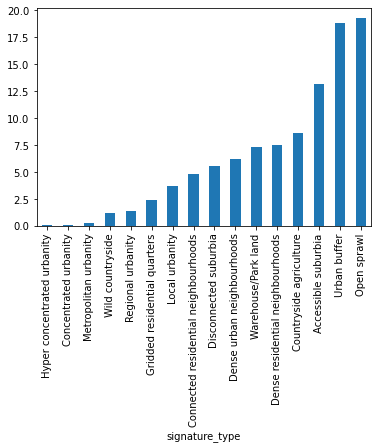

In [41]:
types_sum['population_perc'].sort_values().plot.bar()

<AxesSubplot:xlabel='signature_type'>

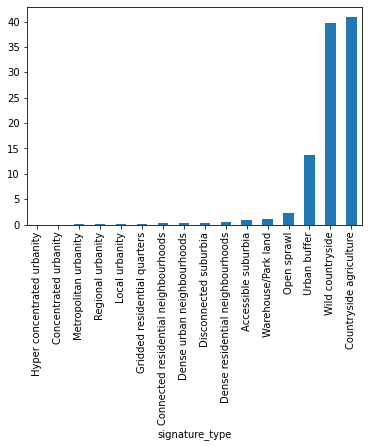

In [43]:
types_sum['area_perc'].sort_values().plot.bar()

<AxesSubplot:xlabel='signature_type'>

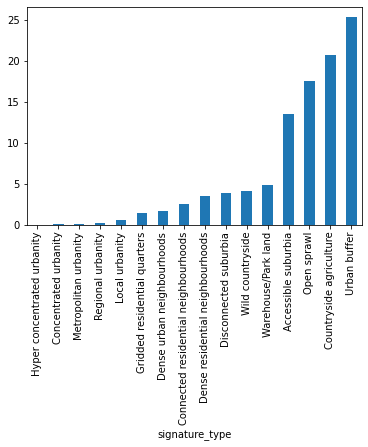

In [44]:
types_sum['count_perc'].sort_values().plot.bar()

In [46]:
types_sum

,area,counts,area_perc,count_perc,population,population_perc
signature_type,,,,,,
Countryside agriculture,9.385615e+10,3022385.0,40.818050,20.787454,5.765794e+06,8.587620
Accessible suburbia,2.244586e+09,1962830.0,0.976171,13.500013,8.848915e+06,13.179644
Dense residential neighbourhoods,9.572622e+08,502835.0,0.416313,3.458414,5.016013e+06,7.470889
Connected residential neighbourhoods,5.654034e+08,374090.0,0.245894,2.572928,3.200903e+06,4.767450
Dense urban neighbourhoods,5.706291e+08,238639.0,0.248167,1.641319,4.160981e+06,6.197399
Open sprawl,5.081598e+09,2561211.0,2.209988,17.615577,1.291983e+07,19.242892
Wild countryside,9.130631e+10,595902.0,39.709124,4.098513,7.738578e+05,1.152590
Warehouse/Park land,2.462472e+09,707211.0,1.070930,4.864078,4.885898e+06,7.277095
Gridded residential quarters,2.612541e+08,209959.0,0.113619,1.444063,1.622579e+06,2.416682
